# Constructing a threshold model based on HST x PS1 (Stack) catalog

I tried three models: a constant, a line, and a broken line which is determined by fitting for star distribution. 

The best parameters of each model are determined to maximize $\it{accuracy}$, and then $\it{roc\ auc\ score}$ and $\it{informdness}$ will be calculated for the models with the best parameters.
For identifying which model/scoring conbination is suitable for star/galaxy separation, psfKronRatio and LogPsfKronRatio (same as [psfMag $-$ KronMag]/2.5) are used for construction the best model, and distance and weighted distance ($\chi$) are used for $\it{roc\ auc\ score}$ and $\it{informdness}$ calculation. 

$\chi$ is weighted distance from the model usually used when data points have an error both for X and Y directions: 

for example TGraph::Chisquare in https://root.cern.ch/doc/master/classTGraph.html 

I think, in the case for example the two data points having an same unweighted distance 10 from the model while different uncertainties 1 and 10 in the distance, the statistical significance of the separation for the former data point should be more significant. 
This is why I adopted chi value instead of a distance, and then the weighted distance of the example is calculated to be 10 and 1 respectively. 

$\chi =$ [y - f(x)]/[$\sigma_y^2$ + ($\sigma_x$ df(x)/dx)$^2$]

is roughly coresponding to $\sigma$ for the normal distribution.
It allows us more statistically precise analysis.

In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
hst_ps1 = pd.read_csv('HST_PS1_stack_tachibana.csv')

Discarding duplicated data

In [2]:
cat = hst_ps1.drop_duplicates(['objID'])
print 'data length %d -> %d' %(len(hst_ps1), len(cat))
del hst_ps1

data length 47983 -> 39839


In [3]:
def plt_hexbin_star_galaxy(xval1, yval1, xval2, yval2, extent, xlab, ylab, 
                           zval=None, vmin=None, vmax=None, zlab=None, bins=None, grid=100, 
                           xscale1='linear', yscale1='linear', xscale2='linear', yscale2='linear', title1='STAR', title2='GALAXY'):
    font = 'sans-serif'
    plt.figure(figsize=(17,4))
    plt.subplot(1,2,1)
    plt.hexbin(xval1, yval1, zval, vmin=vmin, vmax=vmax, extent=extent, cmap='gnuplot', bins=bins, gridsize=grid)
    plt.xscale(xscale1); plt.yscale(yscale1)
    plt.xlim(extent[0:2]); plt.ylim(extent[2:4])
    plt.colorbar().set_label(zlab, fontname='serif', fontsize=15)
    plt.title(title1, fontname=font, fontsize=25)
    plt.xlabel(xlab, fontname=font, fontsize=15)
    plt.ylabel(ylab, fontname=font, fontsize=15)
    plt.subplot(1,2,2)
    plt.hexbin(xval2, yval2, zval, vmin=vmin, vmax=vmax, extent=extent, cmap='gnuplot', bins=bins, gridsize=grid)
    plt.xscale(xscale2); plt.yscale(yscale2)
    plt.xlim(extent[0:2]); plt.ylim(extent[2:4])
    plt.colorbar().set_label(zlab, fontname='serif', fontsize=15)
    plt.title(title2, fontname=font, fontsize=25)
    plt.xlabel(xlab, fontname=font, fontsize=15)
    plt.ylabel(ylab, fontname=font, fontsize=15)

def plt_scatter_star_galaxy(xval1, yval1, xval2, yval2, extent, xlab, ylab, 
                           xscale1='linear', yscale1='linear', xscale2='linear', yscale2='linear', 
                           title1 = 'STAR', title2='GALAXY', alpha = 1, color='blue'):
    font = 'sans-serif'
    plt.figure(figsize=(17,4))
    plt.subplot(1,2,1)
    plt.scatter(xval1, yval1, alpha=alpha, color=color)
    plt.xscale(xscale1); plt.yscale(yscale1)
    plt.xlim(extent[0:2]); plt.ylim(extent[2:4])
    plt.title(title1, fontname=font, fontsize=25)
    plt.xlabel(xlab, fontname=font, fontsize=15)
    plt.ylabel(ylab, fontname=font, fontsize=15)
    plt.subplot(1,2,2)
    plt.scatter(xval2, yval2, alpha=alpha, color=color)
    plt.xscale(xscale2); plt.yscale(yscale2)
    plt.xlim(extent[0:2]); plt.ylim(extent[2:4])
    plt.title(title2, fontname=font, fontsize=25)
    plt.xlabel(xlab, fontname=font, fontsize=15)
    plt.ylabel(ylab, fontname=font, fontsize=15)

In [4]:
star, galaxy = cat.MU_CLASS == 2, cat.MU_CLASS == 1

/Users/tachibana/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


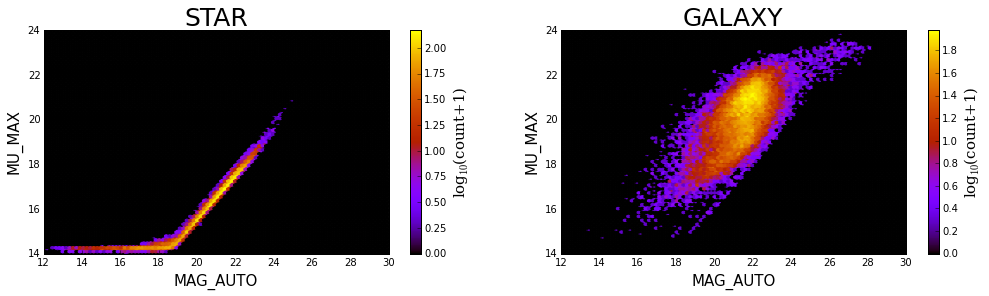

In [5]:
xval1 = cat.MAG_AUTO[star]; yval1 = cat.MU_MAX[star]
xval2 = cat.MAG_AUTO[galaxy]; yval2 = cat.MU_MAX[galaxy]
extent = [12,30,14,24]
xlab = 'MAG_AUTO'; ylab = 'MU_MAX'; zlab='log$_{10}$(count+1)'

plt_hexbin_star_galaxy(xval1, yval1, xval2, yval2, extent, xlab, ylab, zlab=zlab, bins='log')
plt.show(); plt.close()

In galaxy, brightnesses in some sources are calculated to be fainter than 25 mag. 
It might be due to 'contamination' of a faint source within the crossmating region (this time 0.5 arcsec) which cannot be detected by PS1. 
I tentatively cut these source fainter than 24.5 mag in MAG_AUTO. 

In [6]:
mag_mask = cat.MAG_AUTO <= 24.5
star = star&mag_mask; galaxy = galaxy&mag_mask

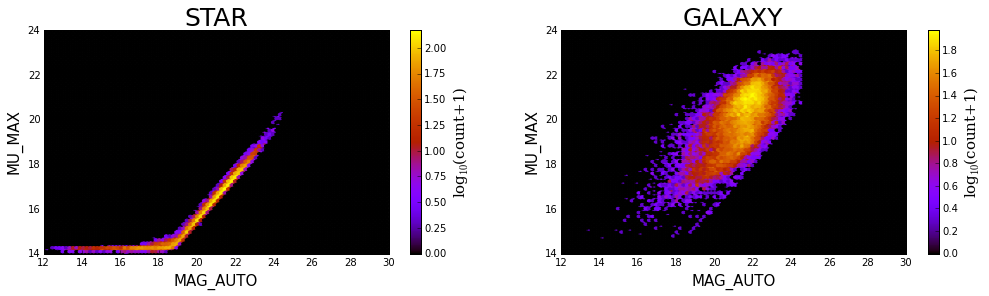

In [7]:
xval1 = cat.MAG_AUTO[star]; yval1 = cat.MU_MAX[star]
xval2 = cat.MAG_AUTO[galaxy]; yval2 = cat.MU_MAX[galaxy]
plt_hexbin_star_galaxy(xval1, yval1, xval2, yval2, extent, xlab, ylab, zlab=zlab, bins='log')
plt.show(); plt.close()

In [8]:
print 'data length %d -> %d' %(len(cat), len(cat[mag_mask]))
cat = cat[mag_mask]

data length 39839 -> 39528


 I intend to include uncertainties in brightness and psfKronRatio for constructing criteria of star/galaxy sparation thus modified the code for calculating the error in psfKronRatio. 

In [9]:
def calc_psfKronRatio(catalog):
    filter_name =  ['g', 'r', 'i', 'z', 'y']
    psfmag_name = 'PSFMag'
    kronmag_name = 'KronMag'
    psfmagerr_name = 'PSFMagErr'
    kronmagerr_name = 'KronMagErr'
    psfmag_list = []
    kronmag_list = []
    psfmagerr_list = []
    kronmagerr_list = []
    for fil in filter_name:
        psfmag_list.append(fil+psfmag_name)
        kronmag_list.append(fil+kronmag_name)
        psfmagerr_list.append(fil+psfmagerr_name)
        kronmagerr_list.append(fil+kronmagerr_name)
    mag_list = psfmag_list + kronmag_list + psfmagerr_list + kronmagerr_list
    PS_mag = cat[mag_list]
    weight_norm = np.zeros(len(PS_mag))
    det_num = np.zeros(len(PS_mag))
    mean_flux_ratio_w =np.zeros(len(PS_mag))
    mean_flux_ratioerr_w =np.zeros(len(PS_mag))

    for fil in filter_name:
        psf_col_name = fil + psfmag_name
        kron_col_name = fil + kronmag_name
        psferr_col_name = fil + psfmagerr_name
        kronerr_col_name = fil + kronmagerr_name

        psf_det_flux = np.power(10, -0.4*(PS_mag[psf_col_name].values + 48.6),                                               
                                                  out = np.zeros_like(mean_flux_ratio_w),
                                                  where = PS_mag[psf_col_name].values != -999)/1e-27

        kron_det_flux = np.power(10, -0.4*(PS_mag[kron_col_name].values + 48.6),
                                                  out = np.zeros_like(mean_flux_ratio_w),
                                                  where = PS_mag[kron_col_name].values != -999)/1e-27

        psferr_det_flux = np.multiply(0.4*np.log(10), psf_det_flux*PS_mag[psferr_col_name],                                               
                                                  out = np.zeros_like(mean_flux_ratio_w),
                                                  where = PS_mag[psf_col_name].values != -999)

        kronerr_det_flux = np.multiply(0.4*np.log(10), kron_det_flux*PS_mag[kronerr_col_name],
                                                  out = np.zeros_like(mean_flux_ratio_w),
                                                  where = PS_mag[kron_col_name].values != -999)

        psf_det_NS = np.divide(psferr_det_flux, psf_det_flux,
                                                  out = np.zeros_like(mean_flux_ratio_w),
                                                  where = PS_mag[psf_col_name].values != -999)

        kron_det_NS = np.divide(kronerr_det_flux, kron_det_flux,
                                                  out = np.zeros_like(mean_flux_ratio_w),
                                                  where = PS_mag[kron_col_name].values != -999)

        mask = (psf_det_flux!=0)&(kron_det_flux!=0)

        flux_ratio = np.divide(psf_det_flux, kron_det_flux, 
                                                  out = np.zeros_like(mean_flux_ratio_w), 
                                                  where = mask)

        flux_ratio_err = np.multiply(flux_ratio, np.sqrt(psf_det_NS**2 +  kron_det_NS**2), 
                                                  out = np.zeros_like(mean_flux_ratio_w), 
                                                  where = mask)

        weight = np.divide(1, flux_ratio_err**2, 
                                                  out = np.zeros_like(mean_flux_ratio_w), 
                                                  where = mask)

        flux_ratio_w = np.multiply(flux_ratio, weight, 
                                                  out = np.zeros_like(mean_flux_ratio_w), 
                                                  where = mask)

        flux_ratioerr_w = np.multiply(flux_ratio_err, weight, 
                                                  out = np.zeros_like(mean_flux_ratio_w), 
                                                  where = mask)

        mean_flux_ratio_w += flux_ratio_w
        mean_flux_ratioerr_w += flux_ratioerr_w
        weight_norm += weight
        det_num += mask.astype(int)

    mask = (mean_flux_ratio_w != 0)&(weight_norm != 0)
    mean_flux_ratio = np.divide(mean_flux_ratio_w, weight_norm, 
                             out = np.zeros_like(mean_flux_ratio_w), 
                             where = mask)
    mean_flux_ratioerr = np.divide(mean_flux_ratioerr_w, weight_norm*np.sqrt(det_num), 
                             out = np.zeros_like(mean_flux_ratio_w), 
                             where = mask)
    
    ratio_kwargs = {'mean_psfKronRatio' : mean_flux_ratio}
    ratioerr_kwargs = {'mean_psfKronRatioerr' : mean_flux_ratioerr}
    PS_mag = PS_mag.assign(**ratio_kwargs); PS_mag = PS_mag.assign(**ratioerr_kwargs)
    return PS_mag

In [10]:
star, galaxy = cat.MU_CLASS == 2, cat.MU_CLASS == 1
GT = cat.MU_CLASS
GT_kwargs = {'mu_class' : GT.values}
PS_mag = calc_psfKronRatio(cat)
PS_mag = PS_mag.assign(**GT_kwargs)
del cat

In [11]:
PS_mag[0:5]

,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag,gKronMag,rKronMag,iKronMag,zKronMag,yKronMag,...,zPSFMagErr,yPSFMagErr,gKronMagErr,rKronMagErr,iKronMagErr,zKronMagErr,yKronMagErr,mean_psfKronRatio,mean_psfKronRatioerr,mu_class
0,21.125900,20.919100,20.852100,20.796600,20.621300,21.1647,21.0355,20.979300,20.911501,20.588100,...,0.038179,0.111345,0.018436,0.017603,0.059011,0.056590,0.163093,1.077099,0.011909,2
1,22.903900,22.465500,22.201500,21.980600,22.171700,22.8293,22.3239,22.127899,21.944300,-999.000000,...,0.124109,0.340539,0.095810,0.083600,0.131049,0.159154,-999.000000,0.913481,0.053034,1
2,18.729099,18.248800,17.832300,17.760900,17.654800,18.7668,18.2414,17.936501,17.860100,17.855700,...,0.005025,0.010106,0.003969,0.003660,0.004425,0.007707,0.015434,1.041632,0.002443,2
3,21.941401,21.550699,21.658501,21.066601,21.271299,22.1385,21.7185,21.783501,21.205601,-999.000000,...,0.051641,0.171952,0.036551,0.028953,0.113987,0.079131,-999.000000,1.173531,0.025030,2
4,20.855600,19.970699,19.736300,19.360901,19.247400,19.6127,18.7731,18.387501,18.143000,18.227301,...,0.011362,0.027622,0.009398,0.005661,0.011521,0.011451,0.025626,0.322869,0.001539,1


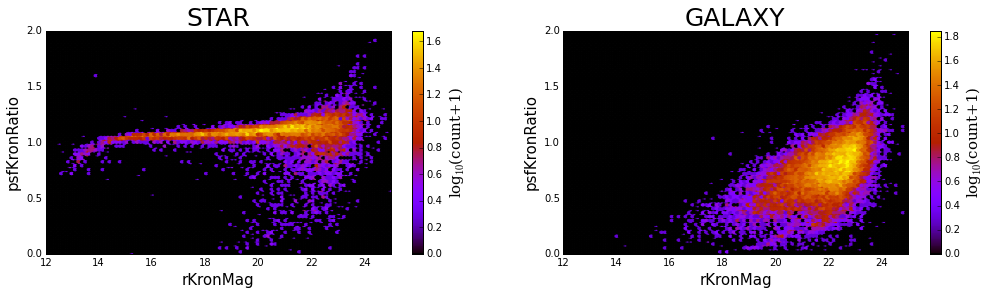

In [12]:
xval1 = PS_mag.rKronMag[star]; yval1 = PS_mag.mean_psfKronRatio[star]
xval2 = PS_mag.rKronMag[galaxy]; yval2 = PS_mag.mean_psfKronRatio[galaxy]
extent = [12,25,0,2]
xlab = 'rKronMag'; ylab = 'psfKronRatio'; zlab='log$_{10}$(count+1)'

plt_hexbin_star_galaxy(xval1, yval1, xval2, yval2, extent, xlab, ylab, zlab=zlab, bins='log')
plt.show(); plt.close()

Uncertainty in psfKronRatio $\Delta R$ is calculated by 

$\Delta R = R \times \sqrt{\left(\frac{\Delta x_1}{x_1}\right)^2 + \left(\frac{\Delta x_2}{x_2}\right)^2} \propto R$

where $x_1$ and $x_2$ is rPsfFlux and rKronFlux respectively. 
Variation in $R$ proportional to itself probably makes the distribution distorting upward exponentially in fainter side. 

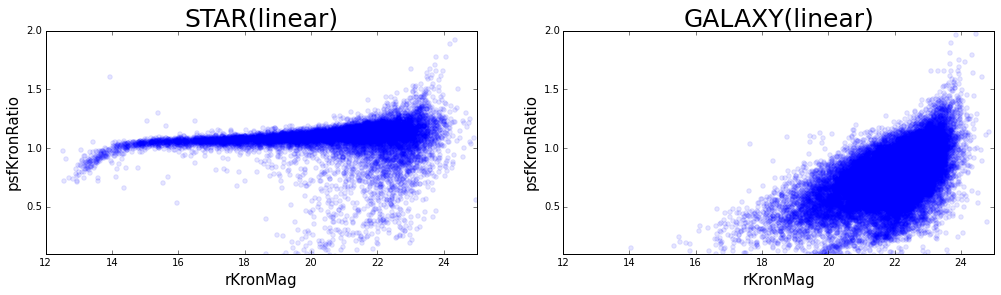

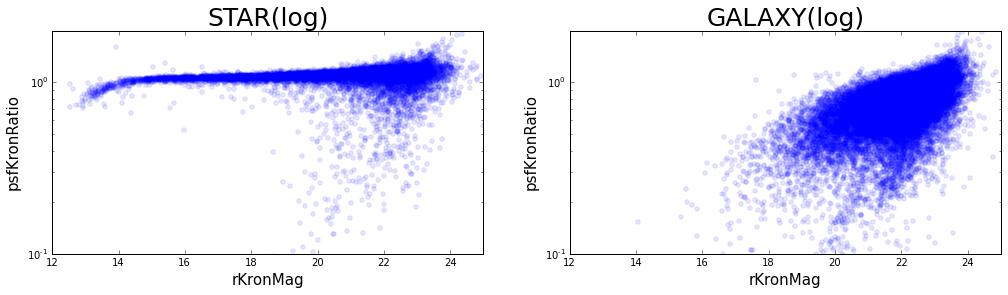

In [13]:
rdet = PS_mag.rKronMag!=-999
Rdet = (PS_mag.mean_psfKronRatio!=0)&(np.isnan(PS_mag.mean_psfKronRatio)==False)
det = rdet&Rdet

xval1 = PS_mag.rKronMag[star&det]; yval1 = PS_mag.mean_psfKronRatio[star&det]
xval2 = PS_mag.rKronMag[galaxy&det]; yval2 = PS_mag.mean_psfKronRatio[galaxy&det]
extent = [12,25,1e-1,2]

plt_scatter_star_galaxy(xval1, yval1, xval2, yval2, extent,xlab = 'rKronMag', ylab = 'psfKronRatio',  
                        title1='STAR(linear)', title2='GALAXY(linear)', alpha=0.1)
plt.show(); plt.close()
plt_scatter_star_galaxy(xval1, yval1, xval2, yval2, extent,xlab = 'rKronMag', ylab = 'psfKronRatio',  
                        title1='STAR(log)', title2='GALAXY(log)', yscale1='log',  yscale2='log', alpha=0.1)
plt.show(); plt.close()

Converting

$R$ = [rPsfFlux]/[rKronFlux] 

to 

$\log_{10}R = \log_{10}$[rPsfFlux]$ - \log_{10}$[rKronFlux] 

for having a linear relationship with rKronMag and for (possibly) justification to separate star/galaxy by a linear threshold (it is proportional to [rPsfMag-rKronMag]).

In [14]:
log_ratio = np.log10(PS_mag.mean_psfKronRatio)
log_ratioerr = PS_mag.mean_psfKronRatioerr/PS_mag.mean_psfKronRatio/np.log(10)
logRatio_kwargs = {'LogPsfKronRatio' : log_ratio.values}
logRatioerr_kwargs = {'LogPsfKronRatioerr' : log_ratioerr.values}
PS_mag = PS_mag.assign(**logRatio_kwargs); PS_mag = PS_mag.assign(**logRatioerr_kwargs)
PS_mag[0:5]

,gPSFMag,rPSFMag,iPSFMag,zPSFMag,yPSFMag,gKronMag,rKronMag,iKronMag,zKronMag,yKronMag,...,gKronMagErr,rKronMagErr,iKronMagErr,zKronMagErr,yKronMagErr,mean_psfKronRatio,mean_psfKronRatioerr,mu_class,LogPsfKronRatio,LogPsfKronRatioerr
0,21.125900,20.919100,20.852100,20.796600,20.621300,21.1647,21.0355,20.979300,20.911501,20.588100,...,0.018436,0.017603,0.059011,0.056590,0.163093,1.077099,0.011909,2,0.032256,0.004802
1,22.903900,22.465500,22.201500,21.980600,22.171700,22.8293,22.3239,22.127899,21.944300,-999.000000,...,0.095810,0.083600,0.131049,0.159154,-999.000000,0.913481,0.053034,1,-0.039301,0.025214
2,18.729099,18.248800,17.832300,17.760900,17.654800,18.7668,18.2414,17.936501,17.860100,17.855700,...,0.003969,0.003660,0.004425,0.007707,0.015434,1.041632,0.002443,2,0.017714,0.001019
3,21.941401,21.550699,21.658501,21.066601,21.271299,22.1385,21.7185,21.783501,21.205601,-999.000000,...,0.036551,0.028953,0.113987,0.079131,-999.000000,1.173531,0.025030,2,0.069495,0.009263
4,20.855600,19.970699,19.736300,19.360901,19.247400,19.6127,18.7731,18.387501,18.143000,18.227301,...,0.009398,0.005661,0.011521,0.011451,0.025626,0.322869,0.001539,1,-0.490973,0.002071


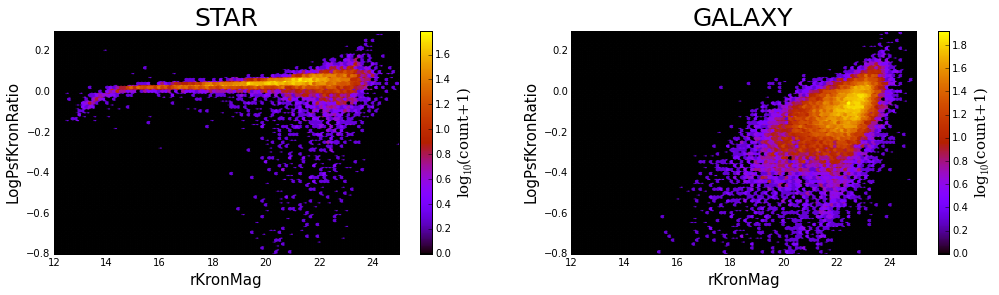

In [15]:
xval1 = PS_mag.rKronMag[star&det]; yval1 = PS_mag.LogPsfKronRatio[star&det]
xval2 = PS_mag.rKronMag[galaxy&det]; yval2 = PS_mag.LogPsfKronRatio[galaxy&det]
xlab = 'rKronMag'; ylab = 'LogPsfKronRatio'
extent = [12,25,-0.8,0.3]

plt_hexbin_star_galaxy(xval1, yval1, xval2, yval2, extent, xlab, ylab, zlab=zlab, bins='log')
plt.show(); plt.close()

## Determining the best parameter for each model with ACU
### Model1 :  Separating star/galaxy by above/beneath of a constant value. 
#### Model1.1: rKronMag vs. psfKronRatio

In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from scipy.optimize import fmin, basinhopping

In [17]:
mag = PS_mag.rKronMag[det]
mag_err = PS_mag.rKronMagErr[det]
pKratio = PS_mag.mean_psfKronRatio[det]
pKratio_err = PS_mag.mean_psfKronRatioerr[det]

GT = np.ones(len(PS_mag))
GT[galaxy] = 0
true = GT[det]

arg = (mag, mag_err, pKratio, pKratio_err, true)

Determining the best threshold by maximize the classification accuracy.  

In [18]:
def calc_acu_const(thre, mag = arg[0], ratio = arg[2], true=arg[4]):
    thre = np.array(thre); mag = np.array(mag); ratio = np.array(ratio)
    st = ratio >= thre; gl = ratio < thre
    pred = np.ones(len(mag))
    pred[gl] = 0
    return -accuracy_score(true, pred)

initval = basinhopping(calc_acu_const,  [1.02079894], niter=500, T=1.0, stepsize=0.1)['x'] # seaching the global minimum by Basin-hopping
fmin(calc_acu_const, initval)

Optimization terminated successfully.
         Current function value: -0.866993
         Iterations: 10
         Function evaluations: 23


array([ 1.02079894])

$\bf{The\ maxumum\ accuracy\ is\ 0.8670\ with\ psfKronRatio\ =\ 1.021}$

#### Model1.2: rKronMag vs. LogPsfKronRatio

In [19]:
def calc_acu_const(thre, mag = arg[0], ratio = PS_mag.LogPsfKronRatio[det], true=arg[4]):
    thre = np.array(thre); mag = np.array(mag); ratio = np.array(ratio)
    st = ratio >= thre; gl = ratio < thre
    pred = np.ones(len(mag))
    pred[gl] = 0
    return -accuracy_score(true, pred)

initval = basinhopping(calc_acu_const,  [0.01075], niter=500, T=1.0, stepsize=0.1)['x']
fmin(calc_acu_const, initval)

Optimization terminated successfully.
         Current function value: -0.866993
         Iterations: 5
         Function evaluations: 12


array([ 0.01071641])

$\bf{The\ maxumum\ accuracy\ is\ 0.8670\ with\ psfKronRatio\ =\ 0.011}$

It is natural the best accuracy is same as Model1.1 ($0.011 \sim \log_{10}[1.021]$ ). 

### Model2 :  Separating star/galaxy by above/beneath of a straight line. 
#### Model2.1: rKronMag vs. psfKronRatio

In [20]:
def calc_acu_line(par, mag = arg[0], ratio = arg[2], true=arg[4]): # model = par[0]*(mag - 14.5) + par[1]
    a, b = np.array(par[0]), np.array(par[1])
    mag, ratio = np.array(mag), np.array(ratio)
    thre = a*(mag-14.5)+b  
    st = ratio >= thre; gl = ratio < thre
    pred = np.ones(len(mag))
    pred[gl] = 0
    return -accuracy_score(true, pred)

initval = basinhopping(calc_acu_line,  [0.07576159,  0.48443631], niter=500, T=1.0, stepsize=0.1)['x'] # seaching the global minimum by Basin-hopping
fmin(calc_acu_line, initval)

Optimization terminated successfully.
         Current function value: -0.904177
         Iterations: 14
         Function evaluations: 40


array([ 0.0756987 ,  0.48535882])

$\bf{The\ maxumum\ accuracy\ is\ 0.9041\ with\ psfKronRatio\ =\ 0.0758\times(rKronMag - 14.5)+0.4844}$

#### Model2.2: rKronMag vs. LogPsfKronRatio

In [21]:
def calc_acu_line(par, mag = arg[0], ratio = PS_mag.LogPsfKronRatio[det], true=arg[4]): 
    a, b = np.array(par[0]), np.array(par[1])
    mag, ratio = np.array(mag), np.array(ratio)
    thre = a*(mag-14.5)+b  
    st = ratio >= thre; gl = ratio < thre
    pred = np.ones(len(mag))
    pred[gl] = 0
    return -accuracy_score(true, pred)

initval = basinhopping(calc_acu_line,  [0.03257589, -0.2256163], niter=500, T=1.0, stepsize=0.1)['x'] # seaching the global minimum by Basin-hopping
fmin(calc_acu_line, initval)

Optimization terminated successfully.
         Current function value: -0.904649
         Iterations: 13
         Function evaluations: 35


array([ 0.03257589, -0.2256163 ])

$\bf{The\ maxumum\ accuracy\ is\ 0.9046\ with\ LogPsfKronRatio\ =\ 0.0326\times(rKronMag - 14.5)-0.2256}$

### Model3 :  Separating star/galaxy by above/beneath of a broken liner. 
#### Model3.1: rKronMag vs. psfKronRatio
Fitting a broken linear function to the distribution of stars on rKronMag vs. psfKronRatio plane. 

In [22]:
mag_st = PS_mag.rKronMag[det&star]
mag_st_err = PS_mag.rKronMagErr[det&star]
pKratio_st = PS_mag.mean_psfKronRatio[det&star]
pKratio_st_err = PS_mag.mean_psfKronRatioerr[det&star]
arg_st = (mag_st, mag_st_err, pKratio_st, pKratio_st_err, true)

def distance_piecewise_linear(x0, y0, k1, k2, x, y,xerr, yerr):
    x0, y0, k1, k2 = np.array(x0), np.array(y0), np.array(k1), np.array(k2)
    x, y, xerr, yerr = np.array(x), np.array(y), np.array(xerr), np.array(yerr)
    pmask =  x < x0
    return np.piecewise(x, [x < x0], [lambda x:-(k1*x-y[pmask]+y0-k1*x0)/np.sqrt((xerr[pmask]*k1)**2+yerr[pmask]**2), 
                                      lambda x:-(k2*x-y[pmask==False]+y0-k2*x0)/np.sqrt((xerr[pmask==False]*k2)**2+yerr[pmask==False]**2)])

def calc_rdchisq_piecewise_linear(par, x=arg_st[0], xerr=arg_st[1], y=arg_st[2],yerr=arg_st[3]):
    chi = distance_piecewise_linear(par[0], par[1], par[2], par[3], x, y, xerr, yerr)
    return (chi**2).sum()/(len(x)-4)

In [23]:
initval = basinhopping(calc_rdchisq_piecewise_linear,  [15.54470676, 1.09278814, 0.09807508, -0.0402001], 
                       niter=100, T=1.0, stepsize=0.1)['x']
fmin(calc_rdchisq_piecewise_linear, initval)

Optimization terminated successfully.
         Current function value: 5652.813438
         Iterations: 81
         Function evaluations: 145


array([ 15.54469996,   1.09278695,   0.09807388,  -0.04020284])

The distribution of star is expressed by 

$psfKronRatio = 0.098\times (rKronMag - 15.5447) + 1.0928\ (rKromMag \leq 15.5447) $ 

$psfKronRatio = -0.040\times (rKronMag - 15.5447) + 1.0928\ (rKromMag > 15.5447) $ 

Determing the threshold by shifting this function along with y-axes to lower direction (1.0928 -> 1.0928$-$bias).

In [24]:
def calc_acu_broken_line(bias, mag = arg[0], ratio = arg[2], true=arg[4]): 
    bias =np.array(bias)
    mag, ratio = np.array(mag), np.array(ratio)
    thre = np.piecewise(mag, [mag < 15.5447], [lambda mag: 0.098*(mag-15.5447)+1.0928, 
                                      lambda mag:  -0.040*(mag-15.5447)+1.0928])
    st = ratio >= (thre - bias); gl = ratio < (thre - bias) 
    pred = np.ones(len(mag))
    pred[gl] = 0
    return -accuracy_score(true, pred)

initval = basinhopping(calc_acu_broken_line,  [0.1], niter=500, T=1.0, stepsize=0.1)['x'] 
fmin(calc_acu_broken_line, initval)

Optimization terminated successfully.
         Current function value: -0.769502
         Iterations: 9
         Function evaluations: 20


array([-0.17632342])

The threshold seems to be not valid because it is pulled upward by galaxy distribution which have much sources than star, and thus the accuracy (0.77) is not so different with the ratio of the galaxy sources ($\sim$0.71). 

#### Model3.2: rKronMag vs. LogPsfKronRatio

In [25]:
def calc_rdchisq_piecewise_linear(par, x=arg_st[0], xerr=arg_st[1], 
                                  y=PS_mag.LogPsfKronRatio[det&star],yerr=PS_mag.LogPsfKronRatioerr[det&star]):
    chi = distance_piecewise_linear(par[0], par[1], par[2], par[3], x, y, xerr, yerr)
    return (chi**2).sum()/(len(x)-4)

initval = basinhopping(calc_rdchisq_piecewise_linear,  [1.45670852e+01, 1.38369273e-02, 5.85413137e-02, 4.36016430e-03], 
                       niter=100, T=1.0, stepsize=0.1)['x']
fmin(calc_rdchisq_piecewise_linear, initval)

Optimization terminated successfully.
         Current function value: 3234.427870
         Iterations: 67
         Function evaluations: 111


array([  1.45670849e+01,   1.38369233e-02,   5.85413192e-02,
         4.36016823e-03])

The distribution of star is expressed by 

$LogPsfKronRatio = 0.059\times (rKronMag - 14.5671) + 0.0138\ (rKromMag \leq 14.5671) $ 

$LogPsfKronRatio = 0.004\times (rKronMag - 14.5671) + 0.0138\ (rKromMag > 14.5671) $ 

Determing the threshold by shifting this function along with y-axes to lower direction (0.0138 -> 0.0138$-$bias).

In [26]:
def calc_acu_broken_line(bias, mag = arg[0], ratio = PS_mag.LogPsfKronRatio[det], true=arg[4]): 
    bias =np.array(bias)
    mag, ratio = np.array(mag), np.array(ratio)
    thre = np.piecewise(mag, [mag < 14.5671], [lambda mag: 0.059*(mag-14.5671)+0.0138, 
                                      lambda mag:  0.004*(mag-14.5671)+0.0138])
    st = ratio >= (thre - bias); gl = ratio < (thre - bias) 
    pred = np.ones(len(mag))
    pred[gl] = 0
    return -accuracy_score(true, pred)

initval = basinhopping(calc_acu_broken_line,  [0.02213907], niter=500, T=1.0, stepsize=0.1)['x'] 
fmin(calc_acu_broken_line, initval)

Optimization terminated successfully.
         Current function value: -0.885390
         Iterations: 6
         Function evaluations: 14


array([ 0.02213907])

$\bf{The\ best\ accuracy\ is\ 0.8854\ with\ the\ bias\ 0.0221. }$

## Accuracy of each model obtained above

In [27]:
columns = ['Cons.', 'Cons.(log)', 'Line', 'Line(log)', 'Brkline', 'Brkline(log)']
indices = ['ACU']
ACU = np.array([0.866993, 0.866965, 0.904149, 0.904649, 0.769502, 0.885390])

df = pd.DataFrame(ACU.reshape(1,6), index=indices, columns=columns)
df

,Cons.,Cons.(log),Line,Line(log),Brkline,Brkline(log)
ACU,0.866993,0.866965,0.904149,0.904649,0.769502,0.88539


## Evaluating ROC AUC score and Informedness for each model
### Model1: Separating star/galaxy by above/beneath of a constant value. 
Threshold = 0$\times$rKronMag + b

In [28]:
def  calc_chi_from_thre(a, b, x, xerr, y, yerr): # model: y = a(x-14.5)+b
    a, b = np.array(a), np.array(b)
    model = (a*(x-14.5)+b).astype(float)
    model_diff = a
    chi = (y - model)/np.sqrt(yerr**2 + (model_diff*xerr)**2)
    return np.array(chi)

#### Model 1.1: rKronMag vs. psfKronRatio

In [29]:
dist1_1 = calc_chi_from_thre(0, 1.02079894, arg[0], 1, arg[2], 1) 
chi1_1 = calc_chi_from_thre(0, 1.02079894, arg[0], arg[1], arg[2], arg[3]) 
rocDist1_1 = roc_auc_score(true, dist1_1 ) # distance scoring
rocChi1_1 = roc_auc_score(true, chi1_1 ) # $\chi$ scoring

print 'ROC AUC score using distance is %1.4f' %rocDist1_1
print 'ROC AUC score using weighted distance is %1.4f' %rocChi1_1

fprDist1_1, tprDist1_1, threshDist1_1 = roc_curve(arg[4], dist1_1)
fprChi1_1, tprChi1_1, threshChi1_1 = roc_curve(arg[4], chi1_1)

print 'The informedness using distance is %1.4f' %np.max(tprDist1_1-fprDist1_1)
print 'The informedness using weighted distance is %1.4f' %np.max(tprChi1_1-fprChi1_1)

ROC AUC score using distance is 0.8894
ROC AUC score using weighted distance is 0.8943
The informedness using distance is 0.7124
The informedness using weighted distance is 0.7048


#### Model 1.2: rKronMag vs. LogPsfKronRatio

In [30]:
dist1_2 = calc_chi_from_thre(0, 0.01075, arg[0], 1, PS_mag.LogPsfKronRatio[det], 1) 
chi1_2 = calc_chi_from_thre(0, 0.01075, arg[0], arg[1], PS_mag.LogPsfKronRatio[det], PS_mag.LogPsfKronRatioerr[det]) 
rocDist1_2 = roc_auc_score(true, dist1_2) # distance scoring
rocChi1_2 = roc_auc_score(true, chi1_2) # $\chi$ scoring

print 'ROC AUC score using distance is %1.4f' %rocDist1_2
print 'ROC AUC score using weighted distance is %1.4f' %rocChi1_2

fprDist1_2, tprDist1_2, threshDist1_2 = roc_curve(arg[4], dist1_2)
fprChi1_2, tprChi1_2, threshChi1_2 = roc_curve(arg[4], chi1_2)

print 'The informedness using distance is %1.4f' %np.max(tprDist1_2-fprDist1_2)
print 'The informedness using weighted distance is %1.4f' %np.max(tprChi1_2-fprChi1_2)

ROC AUC score using distance is 0.8894
ROC AUC score using weighted distance is 0.8889
The informedness using distance is 0.7124
The informedness using weighted distance is 0.6965


### Model2: Separating star/galaxy by above/beneath of a straight line. 
Threshold = a$\times$rKronMag + b
#### Model 2.1: rKronMag vs. psfKronRatio

In [31]:
dist2_1 = calc_chi_from_thre(0.07576159, 0.48443631, arg[0], 1, arg[2], 1) 
chi2_1 = calc_chi_from_thre(0.07576159, 0.48443631, arg[0], arg[1], arg[2], arg[3]) 
rocDist2_1 = roc_auc_score(true, dist2_1) # distance scoring
rocChi2_1 = roc_auc_score(true, chi2_1) # $\chi$ scoring

print 'ROC AUC score using distance is %1.4f' %rocDist2_1
print 'ROC AUC score using weighted distance is %1.4f' %rocChi2_1

fprDist2_1, tprDist2_1, threshDist2_1 = roc_curve(arg[4], dist2_1)
fprChi2_1, tprChi2_1, threshChi2_1 = roc_curve(arg[4], chi2_1)

print 'The informedness using distance is %1.4f' %np.max(tprDist2_1-fprDist2_1)
print 'The informedness using weighted distance is %1.4f' %np.max(tprChi2_1-fprChi2_1)

ROC AUC score using distance is 0.9232
ROC AUC score using weighted distance is 0.9294
The informedness using distance is 0.7571
The informedness using weighted distance is 0.7483


#### Model 2.2: rKronMag vs. LogPsfKronRatio

In [32]:
dist2_2 = calc_chi_from_thre(0.03257589, -0.2256163, arg[0], 1, PS_mag.LogPsfKronRatio[det], 1) 
chi2_2 = calc_chi_from_thre(0.03257589, -0.2256163, arg[0], arg[1], PS_mag.LogPsfKronRatio[det], PS_mag.LogPsfKronRatioerr[det]) 
rocDist2_2 = roc_auc_score(true, dist2_2) # distance scoring
rocChi2_2 = roc_auc_score(true, chi2_2) # $\chi$ scoring

print 'ROC AUC score using distance is %1.4f' %rocDist2_2
print 'ROC AUC score using weighted distance is %1.4f' %rocChi2_2

fprDist2_2, tprDist2_2, threshDist2_2 = roc_curve(arg[4], dist2_2)
fprChi2_2, tprChi2_2, threshChi2_2 = roc_curve(arg[4], chi2_2)

print 'The informedness using distance is %1.4f' %np.max(tprDist2_2-fprDist2_2)
print 'The informedness using weighted distance is %1.4f' %np.max(tprChi2_2-fprChi2_2)

ROC AUC score using distance is 0.9258
ROC AUC score using weighted distance is 0.9295
The informedness using distance is 0.7565
The informedness using weighted distance is 0.7497


### Model3: Separating star/galaxy by above/beneath of a broken linear function. 
Threshold = [broken linear function evaluated by fitting with the distribution of star] - bias
#### Model 3.1: rKronMag vs. psfKronRatio

In [33]:
dist3_1 = distance_piecewise_linear(15.54470676, 1.09278814+0.1763252, 0.09807508, -0.0402001, 
                                    arg[0], arg[2], np.ones(len(arg[0])), np.ones(len(arg[0])))
chi3_1 = distance_piecewise_linear(15.54470676, 1.09278814+0.1763252, 0.09807508, -0.0402001, 
                                   arg[0], arg[2], arg[1], arg[3])
rocDist3_1 = roc_auc_score(true, dist3_1) # distance scoring
rocChi3_1 = roc_auc_score(true, chi3_1) # $\chi$ scoring

print 'ROC AUC score using distance is %1.4f' %rocDist3_1
print 'ROC AUC score using weighted distance is %1.4f' %rocChi3_1

fprDist3_1, tprDist3_1, threshDist3_1 = roc_curve(arg[4], dist3_1)
fprChi3_1, tprChi3_1, threshChi3_1 = roc_curve(arg[4], chi3_1)

print 'The informedness using distance is %1.4f' %np.max(tprDist3_1-fprDist3_1)
print 'The informedness using weighted distance is %1.4f' %np.max(tprChi3_1-fprChi3_1)

ROC AUC score using distance is 0.8139
ROC AUC score using weighted distance is 0.6828
The informedness using distance is 0.5040
The informedness using weighted distance is 0.4240


#### Model 3.2: rKronMag vs. LogpPsfKronRatio

In [34]:
dist3_2 = distance_piecewise_linear(1.45670852e+01, 1.38369273e-02-0.02213907, 5.85413137e-02, 4.36016430e-03, 
                                    arg[0], PS_mag.LogPsfKronRatio[det], np.ones(len(arg[0])), np.ones(len(arg[0])))
chi3_2 = distance_piecewise_linear(1.45670852e+01, 1.38369273e-02-0.02213907, 5.85413137e-02, 4.36016430e-03, 
                                   arg[0], PS_mag.LogPsfKronRatio[det], arg[1], PS_mag.LogPsfKronRatioerr[det])
rocDist3_2 = roc_auc_score(true, dist3_2) # distance scoring
rocChi3_2 = roc_auc_score(true, chi3_2) # $\chi$ scoring

print 'ROC AUC score using distance is %1.4f' %rocDist3_2
print 'ROC AUC score using weighted distance is %1.4f' %rocChi3_2

fprDist3_2, tprDist3_2, threshDist3_2 = roc_curve(arg[4], dist3_2)
fprChi3_2, tprChi3_2, threshChi3_2 = roc_curve(arg[4], chi3_2)

print 'The informedness using distance is %1.4f' %np.max(tprDist3_2-fprDist3_2)
print 'The informedness using weighted distance is %1.4f' %np.max(tprChi3_2-fprChi3_2)

ROC AUC score using distance is 0.9044
ROC AUC score using weighted distance is 0.9085
The informedness using distance is 0.7382
The informedness using weighted distance is 0.7062


## ROC AUC value and informednes of each model obtained above

In [35]:
indices = ['ROC_AUC (Dist.)', 'ROC_AUC (Chi)', 'Inform. (Dist.)', 'Inform. (Chi)']
roc_auc_dist = np.array([rocDist1_1, rocDist1_2, rocDist2_1, rocDist2_2, rocDist3_1, rocDist3_2])
roc_auc_chi = np.array([rocChi1_1, rocChi1_2, rocChi2_1, rocChi2_2, rocChi3_1,  rocChi3_2])
inf_dist = np.array([np.max(tprDist1_1-fprDist1_1), np.max(tprDist1_2-fprDist1_2), np.max(tprDist2_1-fprDist2_1), 
               np.max(tprDist2_2-fprDist2_2), np.max(tprDist3_1-fprDist3_1), np.max(tprDist3_2-fprDist3_2)])
inf_chi = np.array([np.max(tprChi1_1-fprChi1_1), np.max(tprChi1_2-fprChi1_2), np.max(tprChi2_1-fprChi2_1), 
               np.max(tprChi2_2-fprChi2_2), np.max(tprChi3_1-fprChi3_1), np.max(tprChi3_2-fprChi3_2)])
df1 = pd.DataFrame([roc_auc_dist, roc_auc_chi, inf_dist, inf_chi], index=indices, columns=columns)
df =pd.concat([df, df1])
df

,Cons.,Cons.(log),Line,Line(log),Brkline,Brkline(log)
ACU,0.866993,0.866965,0.904149,0.904649,0.769502,0.885390
ROC_AUC (Dist.),0.889369,0.889369,0.923218,0.925824,0.813903,0.904350
ROC_AUC (Chi),0.894279,0.888889,0.929393,0.929534,0.682773,0.908512
Inform. (Dist.),0.712356,0.712356,0.757092,0.756455,0.503960,0.738173
Inform. (Chi),0.704834,0.696459,0.748327,0.749702,0.424010,0.706185


# Plotting 
## ROC AUC curve

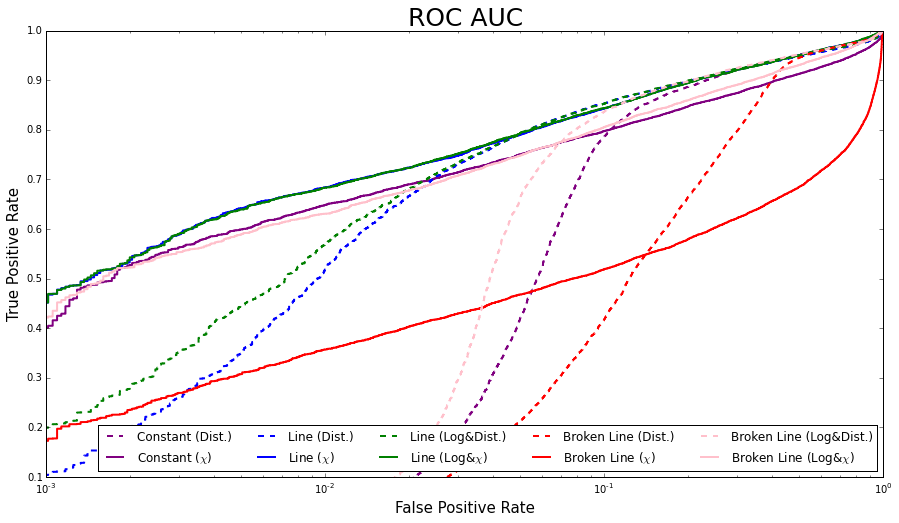

In [36]:
plt.figure(figsize=(15,8))
font = 'sans-serif'
plt.plot(fprDist1_1, tprDist1_1, '--', label='Constant (Dist.)', lw=2, color='purple')
plt.plot(fprChi1_1, tprChi1_1, label='Constant ($\chi$)', lw=2, color='purple')
plt.plot(fprDist2_1, tprDist2_1, '--', label='Line (Dist.)', lw=2, color='blue')
plt.plot(fprChi2_1, tprChi2_1, label='Line ($\chi$)', lw=2, color='blue')
plt.plot(fprDist2_2, tprDist2_2, '--',  label='Line (Log&Dist.)', lw=2, color='green')
plt.plot(fprChi2_2, tprChi2_2, label='Line (Log&$\chi$)', lw=2, color='green')
plt.plot(fprDist3_1, tprDist3_1, '--',  label='Broken Line (Dist.)', lw=2, color='red')
plt.plot(fprChi3_1, tprChi3_1, label='Broken Line ($\chi$)', lw=2, color='red')
plt.plot(fprDist3_2, tprDist3_2, '--',  label='Broken Line (Log&Dist.)', lw=2, color='pink')
plt.plot(fprChi3_2, tprChi3_2, label='Broken Line (Log&$\chi$)', lw=2, color='pink')
plt.title('ROC AUC', fontname=font, fontsize=25)
plt.xlabel('False Positive Rate', fontname=font, fontsize=15)
plt.ylabel('True Positive Rate', fontname=font, fontsize=15)
plt.xlim(1e-3,1);plt.ylim(1e-1,1)
plt.xscale('log');plt.yscale('linear')
plt.legend(loc='best', ncol=5)
plt.show(); plt.close()

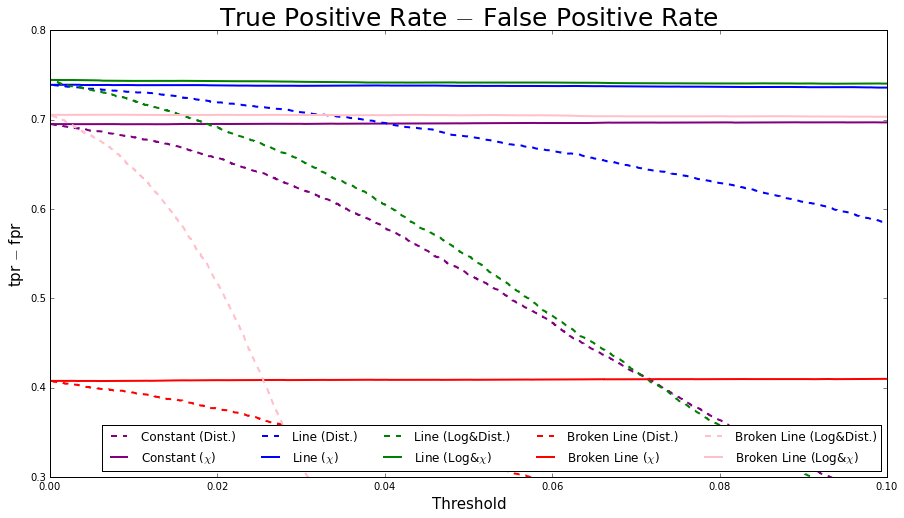

In [37]:
plt.figure(figsize=(15,8))
font = 'sans-serif'
plt.plot(threshDist1_1, tprDist1_1-fprDist1_1, '--', label='Constant (Dist.)', lw=2, color='purple')
plt.plot(threshChi1_1, tprChi1_1-fprChi1_1, label='Constant ($\chi$)', lw=2, color='purple')
plt.plot(threshDist2_1, tprDist2_1-fprDist2_1, '--', label='Line (Dist.)', lw=2, color='blue')
plt.plot(threshChi2_1, tprChi2_1-fprChi2_1, label='Line ($\chi$)', lw=2, color='blue')
plt.plot(threshDist2_2, tprDist2_2-fprDist2_2, '--',  label='Line (Log&Dist.)', lw=2, color='green')
plt.plot(threshChi2_2, tprChi2_2-fprChi2_2, label='Line (Log&$\chi$)', lw=2, color='green')
plt.plot(threshDist3_1, tprDist3_1-fprDist3_1, '--',  label='Broken Line (Dist.)', lw=2, color='red')
plt.plot(threshChi3_1, tprChi3_1-fprChi3_1, label='Broken Line ($\chi$)', lw=2, color='red')
plt.plot(threshDist3_2, tprDist3_2-fprDist3_2, '--',  label='Broken Line (Log&Dist.)', lw=2, color='pink')
plt.plot(threshChi3_2, tprChi3_2-fprChi3_2, label='Broken Line (Log&$\chi$)', lw=2, color='pink')
plt.title('True Positive Rate $-$ False Positive Rate', fontname=font, fontsize=25)
plt.xlabel('Threshold', fontname=font, fontsize=15)
plt.ylabel('tpr $-$ fpr', fontname=font, fontsize=15)
plt.xlim(0,0.1);plt.ylim(0.3,0.8)
plt.legend(loc='lower right', ncol=5)
plt.show(); plt.close()

The best-fit line for the rKronMag vs. LogPsfKronRatio with $\chi$ scoring seems the best model for star/galaxy separation for the HST source.

## The best-fit line for the rKronMag vs. LogPsfKronRatio with $\chi$ scoring

In [38]:
def plt_hexbin_star_galaxy_with_threshold(xval1, yval1, xval2, yval2, extent, xlab, ylab, a, b, 
                           zval1=None, zval2=None, vmin=None, vmax=None, zlab=None, bins=None, 
                           xscale1='linear', yscale1='linear', xscale2='linear', yscale2='linear', grid=100):
    font = 'sans-serif'
    xp = np.arange(np.min(xval1), np.max(xval1), 0.1)
    plt.figure(figsize=(17,4))
    plt.subplot(1,2,1)
    plt.hexbin(xval1, yval1, zval1, vmin=vmin, vmax=vmax, extent=extent, cmap='gnuplot', bins=bins, gridsize=grid)
    plt.plot(xp, (xp-14.5)*a+b,  '--', lw=2, color='green')
    plt.xscale(xscale1); plt.yscale(yscale1)
    plt.xlim(extent[0:2]); plt.ylim(extent[2:4])
    plt.colorbar().set_label(zlab, fontname='serif', fontsize=15)
    plt.title('STAR', fontname=font, fontsize=25)
    plt.xlabel(xlab, fontname=font, fontsize=15)
    plt.ylabel(ylab, fontname=font, fontsize=15)
    plt.subplot(1,2,2)
    plt.hexbin(xval2, yval2, zval2, vmin=vmin, vmax=vmax, extent=extent, cmap='gnuplot', bins=bins, gridsize=grid)
    plt.plot(xp, (xp-14.5)*a+b,  '--', lw=2, color="green")
    plt.xscale(xscale2); plt.yscale(yscale2)
    plt.xlim(extent[0:2]); plt.ylim(extent[2:4])
    plt.colorbar().set_label(zlab, fontname='serif', fontsize=15)
    plt.title('GALAXY', fontname=font, fontsize=25)
    plt.xlabel(xlab, fontname=font, fontsize=15)
    plt.ylabel(ylab, fontname=font, fontsize=15)

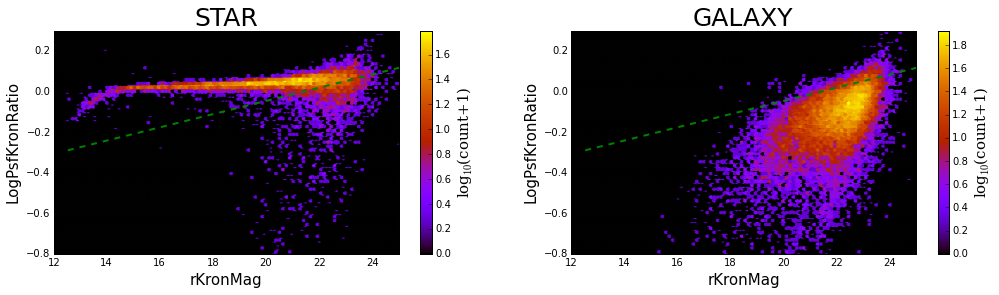

In [39]:
xval1 = PS_mag.rKronMag[star&det]; yval1 = PS_mag.LogPsfKronRatio[star&det]
xval2 = PS_mag.rKronMag[galaxy&det]; yval2 = PS_mag.LogPsfKronRatio[galaxy&det]
xlab = 'rKronMag'; ylab = 'LogPsfKronRatio'
extent = [12,25,-0.8,0.3]

plt_hexbin_star_galaxy_with_threshold(xval1, yval1, xval2, yval2, extent, xlab, ylab, 
                                      0.03257589, -0.2256163, zlab=zlab, bins='log')
plt.show(); plt.close()

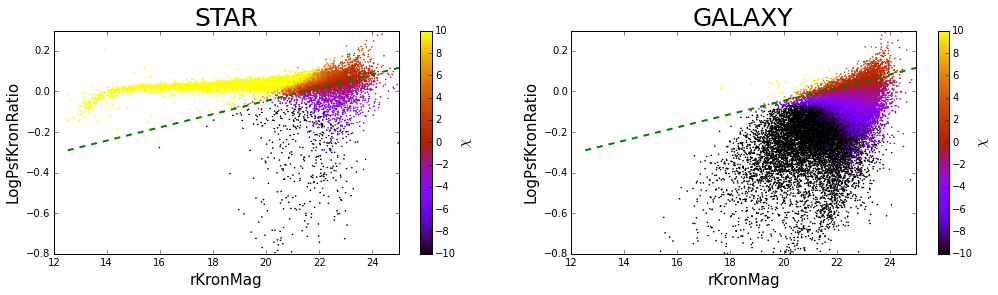

In [40]:
xval1 = PS_mag.rKronMag[star&det]; yval1 = PS_mag.LogPsfKronRatio[star&det]
xval2 = PS_mag.rKronMag[galaxy&det]; yval2 = PS_mag.LogPsfKronRatio[galaxy&det]
chi = calc_chi_from_thre(0.03257589, -0.2256163, 
                         PS_mag.rKronMag, PS_mag.rKronMagErr, PS_mag.LogPsfKronRatio, PS_mag.LogPsfKronRatioerr) 
xlab = 'rKronMag'; ylab = 'LogPsfKronRatio'
extent = [12,25,-0.8,0.3]

plt_hexbin_star_galaxy_with_threshold(xval1, yval1, xval2, yval2, extent, xlab, ylab, 
                                      0.03257589, -0.2256163, zval1 = chi[det&star], zval2=chi[det&galaxy] , vmin=-10, vmax=10, 
                                      zlab='$\chi$', grid=500)
plt.show(); plt.close()

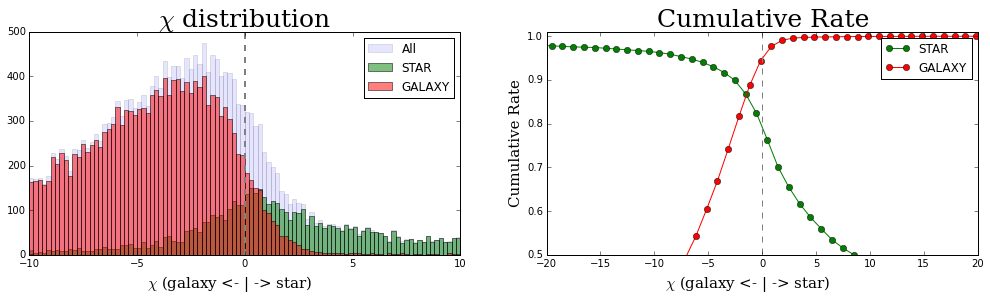

In [41]:
hist_star = plt.hist( -chi[det&star], bins=np.arange(np.min(-chi[det&star]),np.max(-chi[det&star]),1), cumulative=True, normed=True )
hist_galaxy = plt.hist( chi[det&galaxy], bins=np.arange(np.min(chi[det&galaxy]), np.max(chi[det&galaxy]),1), cumulative=True, normed=True )
plt.close()

plt.figure(figsize=(17,4))
plt.subplot(1,2,1)
plt.hist(chi[det], range=(-10, 10), bins=100, alpha=0.1, label='All')
plt.xlim(-10, 10)
plt.ylim(0,500)
plt.hist(chi[det&star], range=(-10, 10), bins=100, alpha=0.5, label='STAR')
plt.hist(chi[det&galaxy], range=(-10, 10), bins=100, alpha=0.5, label='GALAXY')
plt.plot([0,0], [0,500], '--', lw=2, color='grey')
plt.title('$\chi$ distribution', fontname='serif', fontsize=25)
plt.xlabel('$\chi$ (galaxy <- | -> star)       ', fontname='serif', fontsize=15)
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(-hist_star[1][1:len(hist_star[1])], hist_star[0], 'o-', label='STAR', color='green')
plt.plot(hist_galaxy[1][1:len(hist_galaxy[1])], hist_galaxy[0], 'o-', label='GALAXY', color='red')
plt.plot([0, 0], [0, 2], '--', color='grey')
plt.xlabel('$\chi$ (galaxy <- | -> star)       ' , fontname='serif', fontsize=15)
plt.ylabel('Cumulative Rate' , fontname='serif', fontsize=15)
plt.title('Cumulative Rate', fontname='serif', fontsize=25)
plt.legend(loc='best')
plt.xlim(-20, 20)
plt.ylim(0.5, 1.01)

plt.show();plt.close()

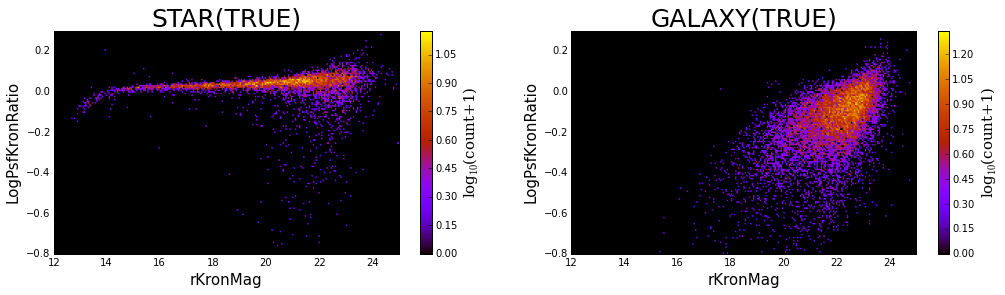

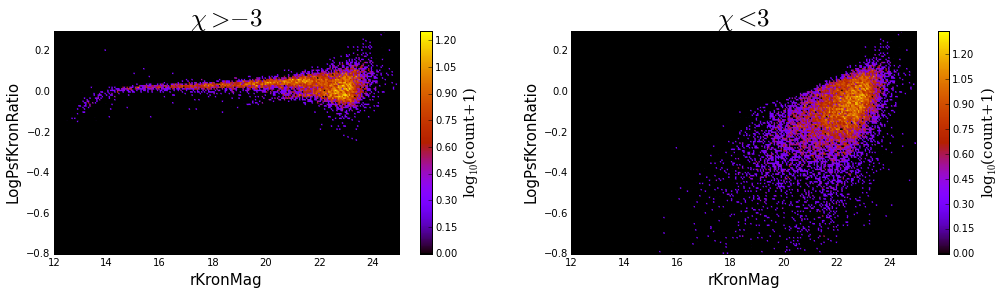

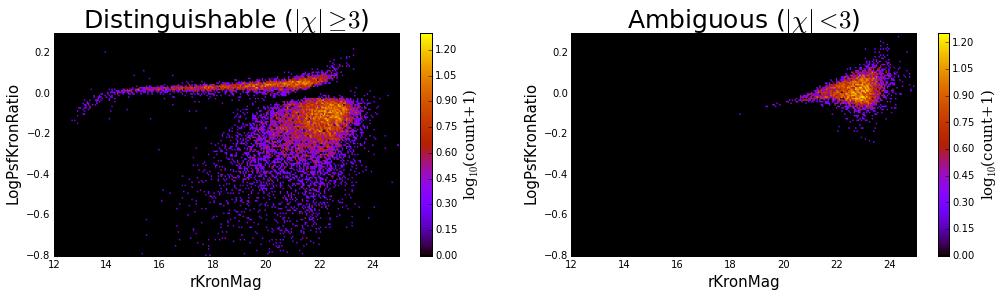

In [42]:
tol = 3 #3 sigma is corresponding 99.7% for the normal distribution
xval = PS_mag.rKronMag[det]; yval = PS_mag.LogPsfKronRatio[det]
xlab = 'rKronMag'; ylab = 'LogPsfKronRatio'
extent = [12,25,-0.8,0.3]
star3 = chi[det] > -tol
galaxy3 = chi[det] < tol
plt_hexbin_star_galaxy(xval[det&star], yval[det&star], xval[det&galaxy], yval[det&galaxy], 
                       extent, xlab, ylab, bins='log', title1='STAR(TRUE)', title2='GALAXY(TRUE)', zlab=zlab, grid=250)
plt_hexbin_star_galaxy(xval[star3], yval[star3], xval[galaxy3], yval[galaxy3],
                       extent, xlab, ylab, bins='log', title1='$\chi > -3$', title2 = '$\chi < 3$',  zlab=zlab, grid=250)
plt_hexbin_star_galaxy(xval[np.abs(chi[det])>=3], yval[np.abs(chi[det])>=3], xval[np.abs(chi[det])<3], yval[np.abs(chi[det])<3],
                       extent, xlab, ylab, bins='log', title1='Distinguishable ($| \chi |\geq3$)', title2 = 'Ambiguous ($| \chi |<3$)',  zlab=zlab, grid=250)

In [43]:
thre_list = 10**np.arange(-2,3, 0.1)
ACU_list = []
for i in range(0, len(thre_list)-1):
    chi_mask = (thre_list[i] <= np.abs(chi))&(np.abs(chi) < thre_list[i+1])
    true = GT[det&chi_mask]
    pred = np.ones(len(GT)); pred[chi<0] = 0; pred = pred[det&chi_mask]
    ACU_list.append(accuracy_score(true, pred))

In [44]:
hist = plt.hist(np.abs(chi[det]), 
                bins=10**np.arange(np.log10(np.min(np.abs(chi[det]))), np.log10(np.max(np.abs(chi[det]))), 0.1), normed=True)
plt.close()

In [45]:
hist_bin = hist[1]
hist_dens = hist[0]
hist_bin = hist_bin[0:(len(hist_bin)-1)]
thre_bin = thre_list[0:(len(thre_list)-1)]

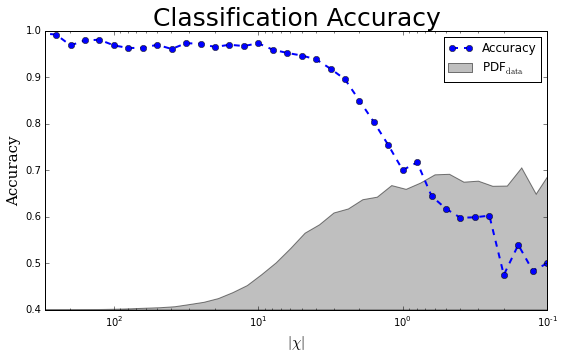

In [46]:
plt.figure(figsize=(9,5))
x = np.concatenate((hist_bin,hist_bin[::-1]) )
y = np.concatenate( (hist_dens, np.zeros(len(hist_dens))) )
plt.fill(x, 3*y+0.4, facecolor='grey', alpha=0.5, label='PDF$_{\mathrm{data}}$')
plt.plot(thre_list[0:(len(thre_list)-1)], ACU_list, 'o--', lw=2, label='Accuracy')
plt.xlabel('$|\chi|$' , fontname='serif', fontsize=15)
plt.ylabel('Accuracy' , fontname='serif', fontsize=15)
plt.title('Classification Accuracy', fontsize=25)
plt.xlim(300, 1e-1); plt.ylim(0.4, 1.0)
plt.xscale('log')
plt.legend(loc='best')
plt.show();plt.close()